# Измерение производительности JIT-компиляции

Будут сравниваться четыре подхода:
1. Питон без улучшений
2. С аннотацией `@jit`
3. С аннотацией `@numba.jit`
4. Тесты для PyPy доступны по
[ссылке](https://github.com/PenzaStreetGames/MetaStruct/blob/main/report/calculations/pypy.py),
[результаты](https://github.com/PenzaStreetGames/MetaStruct/blob/main/report/calculations/pypy_performance.json)

In [1]:
from annotation import jit
from timeit import timeit, repeat
import numba

import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
def get_jit_numba_realisations(func):
    """По входной функции возвращает две оптимизации"""
    jit_func = jit(func)
    numba_func = numba.jit(func, nopython=True)
    return jit_func, numba_func

## Замеры времени компиляции

In [4]:
def py_sum(x: int, y: int) -> int:
    res: int = x + y
    return res

In [4]:
jit_time = repeat(lambda: jit(py_sum), repeat=10, number=1)
jit_time

[0.12362709999433719,
 0.07699030000367202,
 0.07569739999598823,
 0.07125889998860657,
 0.07256569998571649,
 0.07348590000765398,
 0.06936300001689233,
 0.07112749997759238,
 0.07719340000767261,
 0.07802680000895634]

In [5]:
numba_jit_time = repeat(lambda: numba.jit(py_sum), repeat=10, number=1)
numba_jit_time

[0.02519010001560673,
 9.300000965595245e-05,
 5.950001650489867e-05,
 5.5500015150755644e-05,
 5.299999611452222e-05,
 5.299999611452222e-05,
 5.2499992307275534e-05,
 5.189998773857951e-05,
 5.1700015319511294e-05,
 5.190001684240997e-05]

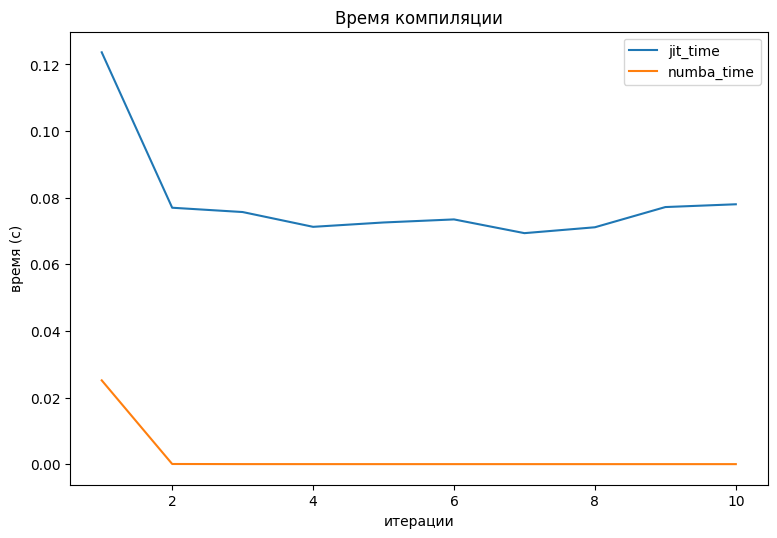

In [62]:
xs = range(1, 11)

plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(xs, jit_time, label='jit_time')
plt.plot(xs, numba_jit_time, label='numba_time')
plt.xlabel('итерации')
plt.ylabel('время (с)')
plt.title('Время компиляции')
plt.legend()
plt.savefig("report/plots/compile_sum.png")
plt.show()

Выводы:
* Компиляция в @numba.jit происходит быстрее в 5 раз
* @numba.jit не выполняет повторную компиляцию модуля, за счёт чего экономит время

## Замеры времени нескольких вызовов

In [7]:
jit_sum = jit(py_sum)
numba_sum = numba.jit(py_sum)


In [95]:
python_exec_time = repeat(lambda: py_sum(2, 2), repeat=10, number=1)
print(python_exec_time)
jit_exec_time = repeat(lambda: jit_sum(2, 2), repeat=10, number=1)
print(jit_exec_time)
numba_exec_time = repeat(lambda: numba_sum(2, 2), repeat=10, number=1)
print(numba_exec_time)

[2.1999876480549574e-06, 3.00002284348011e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 1.00000761449337e-07, 2.00001522898674e-07, 2.00001522898674e-07]
[8.299975888803601e-06, 9.00006853044033e-07, 7.999769877642393e-07, 2.400018274784088e-06, 2.500019036233425e-06, 2.2999884095042944e-06, 6.00004568696022e-07, 3.1999952625483274e-06, 5.999754648655653e-07, 7.00005330145359e-07]
[5.2000104915350676e-06, 4.00003045797348e-07, 2.999731805175543e-07, 3.00002284348011e-07, 2.00001522898674e-07, 2.00001522898674e-07, 2.00001522898674e-07, 3.00002284348011e-07, 2.00001522898674e-07, 2.00001522898674e-07]


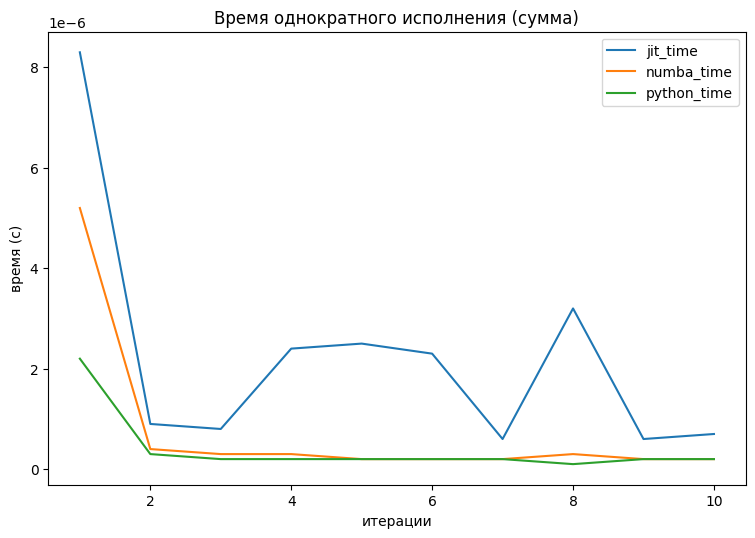

In [96]:
xs = range(1, 11)
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(xs, jit_exec_time, label='jit_time')
plt.plot(xs, numba_exec_time, label='numba_time')
plt.plot(xs, python_exec_time, label='python_time')
plt.xlabel('итерации')
plt.ylabel('время (с)')
plt.title('Время однократного исполнения (сумма)')
plt.legend()
plt.savefig("report/plots/exec_sum_once.png")
plt.show()

Выводы:
* У функции с аннотацией @numba.jit неприлично большое время первого запуска. Видимо, при первом запуске
выполняются некоторые этапы компиляции.

## Усреднённые значения вызовов на простой функции

In [6]:
with open("pypy_performance.json", "r") as infile:
    pypy = json.loads(infile.read())
print(pypy)

{'sum': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0.0038488999999999997, 0.0018897000000000002, 0.0019385000000000001, 0.0018919000000000002, 0.0018849000000000001, 0.001883600000000001, 0.0018922999999999995, 0.0018784000000000006, 0.001886800000000001, 0.0018708000000000023]], 'exp': [[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250], [0.0173366, 0.0120737, 0.012837500000000002, 0.014937800000000001, 0.0169473, 0.019040100000000004, 0.02112749999999998, 0.02316760000000001, 0.025006100000000003, 0.0268872, 0.029473199999999977, 0.031443, 0.033416800000000024, 0.04001710000000003, 0.03720640000000003, 0.039128899999999966, 0.041793599999999986, 0.043902099999999944, 0.04526169999999996, 0.047187199999999985, 0.049909300000000045, 0.05159379999999991, 0.053566400000000014, 0.05532210000000004, 0.057753400000000066]], 'hash': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0.004687900000000078, 0.0018479999999999608, 0.0018389000000000877, 

In [10]:
python_exec_time = repeat(lambda: py_sum(2, 2), repeat=10, number=1000000)
print(python_exec_time)
print(np.var(python_exec_time))
jit_exec_time = repeat(lambda: jit_sum(2, 2), repeat=10, number=1000000)
print(jit_exec_time)
print(np.var(jit_exec_time))
numba_exec_time = repeat(lambda: numba_sum(2, 2), repeat=10, number=1000000)
print(numba_exec_time)
print(np.var(numba_exec_time))

[0.10355010000057518, 0.09889719996135682, 0.09956819994840771, 0.10668550000991672, 0.12663419998716563, 0.11360149999381974, 0.09902900003362447, 0.09885740000754595, 0.09883019997505471, 0.09860180004034191]
7.62803534320121e-05
[0.4468261000001803, 0.44315890001598746, 0.44319009996252134, 0.44309730001259595, 0.44360699999378994, 0.44705790001899004, 0.44258309999713674, 0.44310229999246076, 0.4502494999906048, 0.43504070001654327]
1.413734758702382e-05
[0.15904360002605245, 0.15928739996161312, 0.15715099999215454, 0.15555780002614483, 0.15595400001620874, 0.1546634000260383, 0.1559718000353314, 0.15616160002537072, 0.15396869997493923, 0.15568080003140494]
2.645100625159101e-06


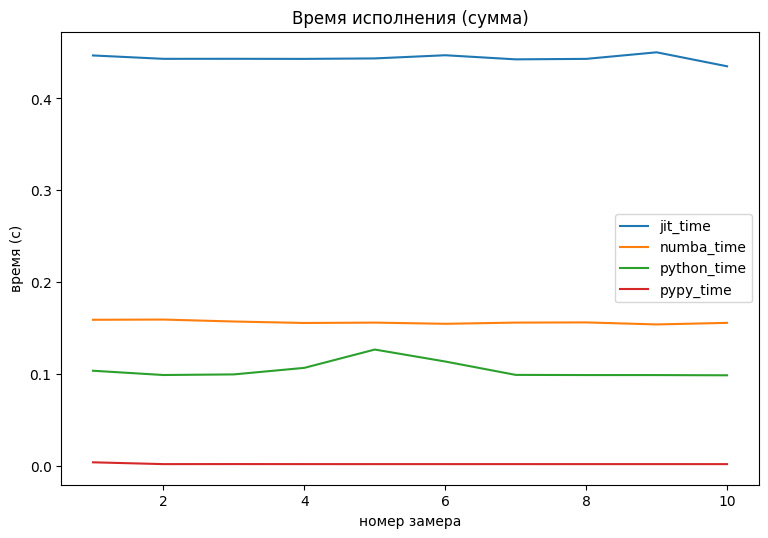

In [11]:
xs = range(1, 11)
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(xs, jit_exec_time, label='jit_time')
plt.plot(xs, numba_exec_time, label='numba_time')
plt.plot(xs, python_exec_time, label='python_time')
plt.plot(xs, pypy["sum"][1], label='pypy_time')
plt.xlabel('номер замера')
plt.ylabel('время (с)')
plt.title('Время исполнения (сумма)')
plt.legend()
plt.savefig("report/plots/exec_sum.png")
plt.show()

Выводы:
* На простых функциях питон без jit-компиляции выполняется быстрее, чем с ней.
* И всё-таки на простых функциях numba проигрывает Питону в 1,5 раза, а ручная jit аннотация в 4,5.

## Измерение скорости выполнения

### Функция вычисления экспоненты с помощью разложения в ряд Тейлора

In [4]:
def py_exp(x: float) -> float:
    res: float = 0
    threshold: float = 1e-30
    delta: float = 1
    elements: int = 0
    while delta > threshold:
        elements = elements + 1
        delta = delta * x / elements
    while elements >= 0:
        res += delta
        delta = delta * elements / x
        elements -= 1
    return res

jit_exp, numba_exp = get_jit_numba_realisations(py_exp)


In [5]:
arg = 250
print(f"exp({arg}) = {jit_exp(arg):.30f}")
args = range(10, 260, 10)
jit_exp_time, numba_exp_time, python_exp_time = [], [], []
for arg in args:
    jit_exp_time.append(timeit(lambda: jit_exp(arg), number=10000))
    numba_exp_time.append(timeit(lambda: numba_exp(arg), number=10000))
    python_exp_time.append(timeit(lambda: py_exp(arg), number=10000))
print(jit_exp_time)
print(numba_exp_time)
print(python_exp_time)

exp(250) = 3746454614502660877998657881484689260451454624001099543290316630153610787704025897267034669677141296546840576.000000000000000000000000000000
[0.009695900022052228, 0.013131099985912442, 0.014009200036525726, 0.015845399990212172, 0.01812139997491613, 0.020196500001475215, 0.022555199975613505, 0.02454999997280538, 0.026248900045175105, 0.02861130004748702, 0.030235700018238276, 0.031980899977497756, 0.0342724000220187, 0.03634099999908358, 0.03824199998052791, 0.04014229995664209, 0.04210030002286658, 0.044263499963562936, 0.04640699998708442, 0.04815769998822361, 0.05005320004420355, 0.052167900023050606, 0.054258399992249906, 0.05635599995730445, 0.058024699974339455]
[0.567600299953483, 0.01012230000924319, 0.011942500015720725, 0.014065199997276068, 0.01633319997927174, 0.018519499979447573, 0.020854200003668666, 0.02275269996607676, 0.024432300007902086, 0.026980700029525906, 0.0283015999593772, 0.030376599985174835, 0.03240979998372495, 0.034880599996540695, 0.03668110

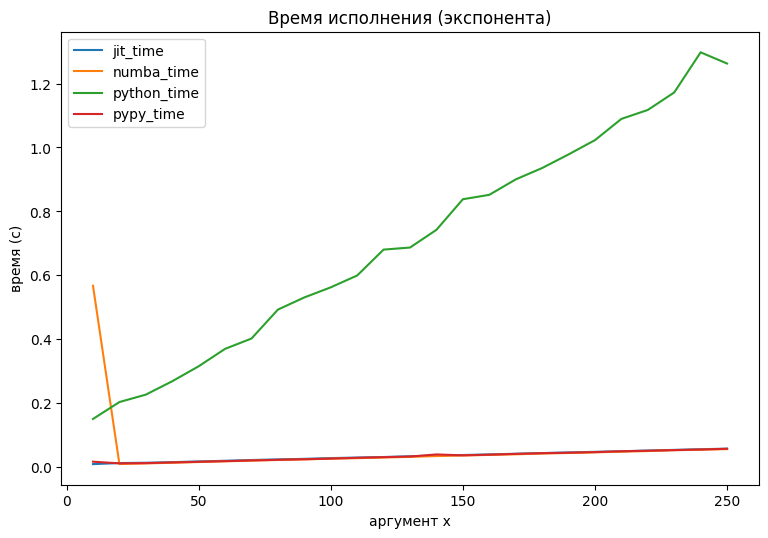

In [8]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_exp_time, label='jit_time')
plt.plot(args, numba_exp_time, label='numba_time')
plt.plot(args, python_exp_time, label='python_time')
plt.plot(args, pypy["exp"][1], label='pypy_time')
plt.xlabel('аргумент x')
plt.ylabel('время (с)')
plt.title('Время исполнения (экспонента)')
plt.legend()
plt.savefig("report/plots/exec_exp_3.png")
plt.show()

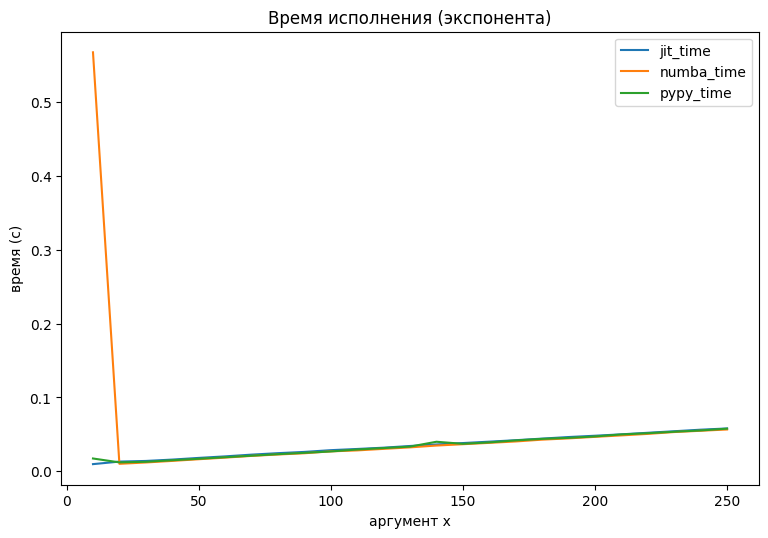

In [7]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_exp_time, label='jit_time')
plt.plot(args, numba_exp_time, label='numba_time')
plt.plot(args, pypy["exp"][1], label='pypy_time')
plt.xlabel('аргумент x')
plt.ylabel('время (с)')
plt.title('Время исполнения (экспонента)')
plt.legend()
plt.savefig("report/plots/exec_exp_2.png")
plt.show()

Выводы:
* Аномалия первого запуска numba функции была обсуждена ранее
* На больших алгоритмических сложностях питон сдаёт позиции
* Отличие производительности двух методов оптимизации незначительно на больших значениях аргумента

### Простая хеш-функция для целых чисел

In [18]:
def py_hash(x: int) -> int:
    x = ((x >> 16) ^ x) * 0x45d9f3b
    x = ((x >> 16) ^ x) * 0x45d9f3b
    x = (x >> 16) ^ x
    return x


jit_hash, numba_hash = get_jit_numba_realisations(py_hash)

In [19]:
python_exec_time = repeat(lambda: py_hash(42), repeat=10, number=1000000)
print(python_exec_time)
jit_exec_time = repeat(lambda: jit_hash(42), repeat=10, number=1000000)
print(jit_exec_time)
numba_exec_time = repeat(lambda: numba_hash(42), repeat=10, number=1000000)
print(numba_exec_time)

[0.3502934999996796, 0.3807980000274256, 0.3268199000158347, 0.33872459997655824, 0.3267561999964528, 0.3374119999934919, 0.3446449000039138, 0.343524600029923, 0.34039009996922687, 0.34055580000858754]
[0.3389805000042543, 0.33606940001482144, 0.3371667999890633, 0.33513080002740026, 0.33663089998299256, 0.3365176999941468, 0.3352549999835901, 0.33328349998919293, 0.3419603999936953, 0.40383500000461936]
[0.19868190004490316, 0.16273280000314116, 0.1576202999567613, 0.15744660003110766, 0.1560901000048034, 0.15683190000709146, 0.15660700004082173, 0.15423729998292401, 0.15543869999237359, 0.15602559997932985]


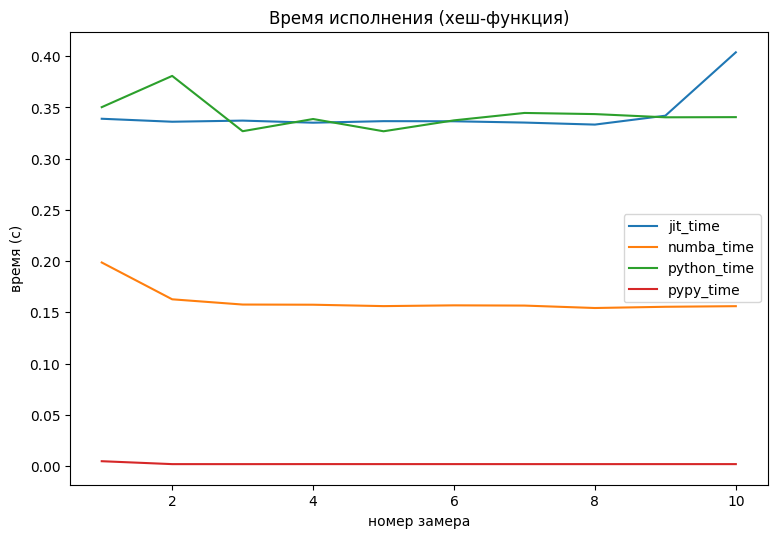

In [20]:
xs = range(1, 11)
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(xs, jit_exec_time, label='jit_time')
plt.plot(xs, numba_exec_time, label='numba_time')
plt.plot(xs, python_exec_time, label='python_time')
plt.plot(xs, pypy["hash"][1], label='pypy_time')
plt.xlabel('номер замера')
plt.ylabel('время (с)')
plt.title('Время исполнения (хеш-функция)')
plt.legend()
plt.savefig("report/plots/exec_hash.png")
plt.show()

Выводы:
* То что функция @jit работает примерно с такой же скоростью, как и питон, не вызывает вопросов
* Но откуда у numba оптимизация на битовых операциях (?)

### Числа Фибоначчи

In [21]:
def py_fib(n: int) -> int:
    if n < 2:
        return 1
    return py_fib(n - 1) + py_fib(n - 2)

@jit
def jit_fib(n: int) -> int:
    if n < 2:
        return 1
    return jit_fib(n - 1) + jit_fib(n - 2)

@numba.jit(nopython=True)
def numba_fib(n: int) -> int:
    if n < 2:
        return 1
    return numba_fib(n - 1) + numba_fib(n - 2)

In [22]:
arg = 30
print(f"fib({arg}) = {jit_fib(arg)}")
args = range(1, 31)
jit_fib_time, numba_fib_time, python_fib_time = [], [], []
for arg in args:
    jit_fib_time.append(timeit(lambda: jit_fib(arg), number=10))
    numba_fib_time.append(timeit(lambda: numba_fib(arg), number=10))
    python_fib_time.append(timeit(lambda: py_fib(arg), number=10))
print(jit_fib_time)
print(numba_fib_time)
print(python_fib_time)

fib(30) = 1346269
[0.00016200001118704677, 5.399982910603285e-06, 4.599976819008589e-06, 4.599976819008589e-06, 4.599976819008589e-06, 4.700035788118839e-06, 4.999979864805937e-06, 5.099980626255274e-06, 5.399982910603285e-06, 5.699985194951296e-06, 6.499991286545992e-06, 7.599999662488699e-06, 9.299954399466515e-06, 1.1299969628453255e-05, 1.4499993994832039e-05, 2.2199994418770075e-05, 3.190001007169485e-05, 5.670002428814769e-05, 8.28000484034419e-05, 0.0001504000392742455, 0.0002175000263378024, 0.0003917999565601349, 0.0005727999960072339, 0.0010370999807491899, 0.0014340000343509018, 0.0024785000132396817, 0.003687900025397539, 0.006098699988797307, 0.009295199997723103, 0.015359500015620142]
[0.05383819999406114, 2.800021320581436e-06, 2.300017513334751e-06, 2.300017513334751e-06, 2.600019797682762e-06, 2.8999638743698597e-06, 3.200024366378784e-06, 3.8000289350748062e-06, 4.799978341907263e-06, 6.399990525096655e-06, 8.899951353669167e-06, 1.2899981811642647e-05, 1.950003206729

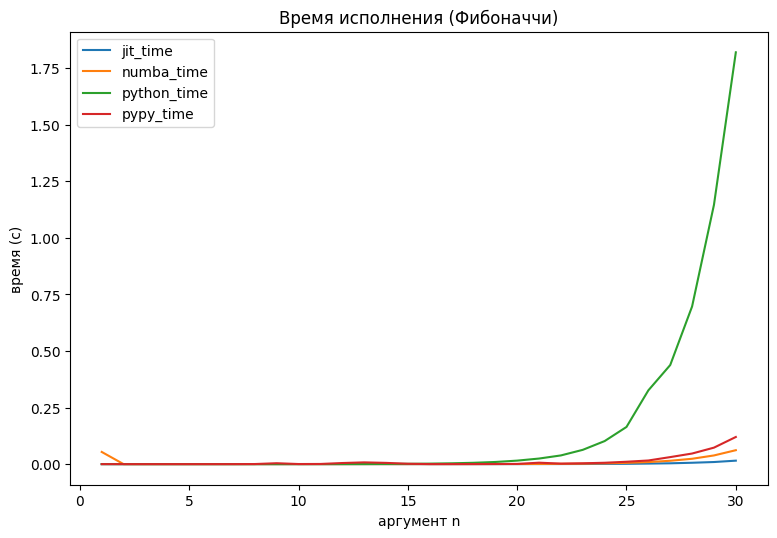

In [23]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_fib_time, label='jit_time')
plt.plot(args, numba_fib_time, label='numba_time')
plt.plot(args, python_fib_time, label='python_time')
plt.plot(args, pypy["fib"][1], label='pypy_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (Фибоначчи)')
plt.legend()
plt.savefig("report/plots/exec_fib_3.png")
plt.show()

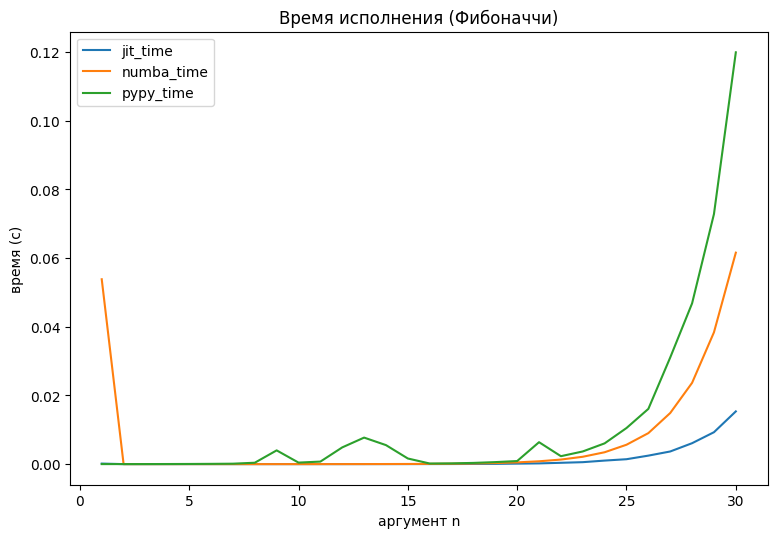

In [25]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_fib_time, label='jit_time')
plt.plot(args, numba_fib_time, label='numba_time')
plt.plot(args, pypy["fib"][1], label='pypy_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (Фибоначчи)')
plt.legend()
plt.savefig("report/plots/exec_fib_2.png")
plt.show()

Выводы:
* На задачах рекурсии реализованный алгоритм показывается себя не так уж и плохо
(до 4-кратного ускорения на данном примере)

### Функция факториала

In [24]:
def py_fact(n: int) -> int:
    if n < 2:
        return 1
    return n * py_fact(n - 1)

@jit
def jit_fact(n: int) -> int:
    if n < 2:
        return 1
    return n * jit_fact(n - 1)

@numba.jit
def numba_fact(n: int) -> int:
    if n < 2:
        return 1
    return n * numba_fact(n - 1)

In [78]:
arg = 10
print(f"fib({arg}) = {jit_fact(arg)}")
args = range(1, 40)
jit_fact_time, numba_fact_time, python_fact_time = [], [], []
for arg in args:
    jit_fact_time.append(timeit(lambda: jit_fact(arg), number=10))
    numba_fact_time.append(timeit(lambda: numba_fact(arg), number=10))
    python_fact_time.append(timeit(lambda: py_fact(arg), number=10))
print(jit_fact_time)
print(numba_fact_time)
print(python_fact_time)

fib(10) = 3628800
[1.7099984688684344e-05, 7.90000194683671e-06, 6.699992809444666e-06, 6.799993570894003e-06, 6.699992809444666e-06, 7.199996616691351e-06, 6.999995093792677e-06, 7.099995855242014e-06, 6.700021913275123e-06, 6.89999433234334e-06, 6.699992809444666e-06, 6.799993570894003e-06, 6.999995093792677e-06, 6.89999433234334e-06, 6.799993570894003e-06, 7.099995855242014e-06, 6.89999433234334e-06, 7.399998139590025e-06, 6.999995093792677e-06, 7.199996616691351e-06, 8.000002708286047e-06, 1.3199984095990658e-05, 8.200004231184721e-06, 7.299997378140688e-06, 7.399998139590025e-06, 7.299997378140688e-06, 8.299975888803601e-06, 7.299997378140688e-06, 7.099995855242014e-06, 6.999995093792677e-06, 9.799987310543656e-06, 7.199996616691351e-06, 1.0000017937272787e-05, 9.599985787644982e-06, 7.489998824894428e-05, 1.0399991879239678e-05, 1.0099989594891667e-05, 9.299983503296971e-06, 0.00019069999689236283]
[8.299975888803601e-06, 2.2999884095042944e-06, 2.0999868866056204e-06, 2.39998917

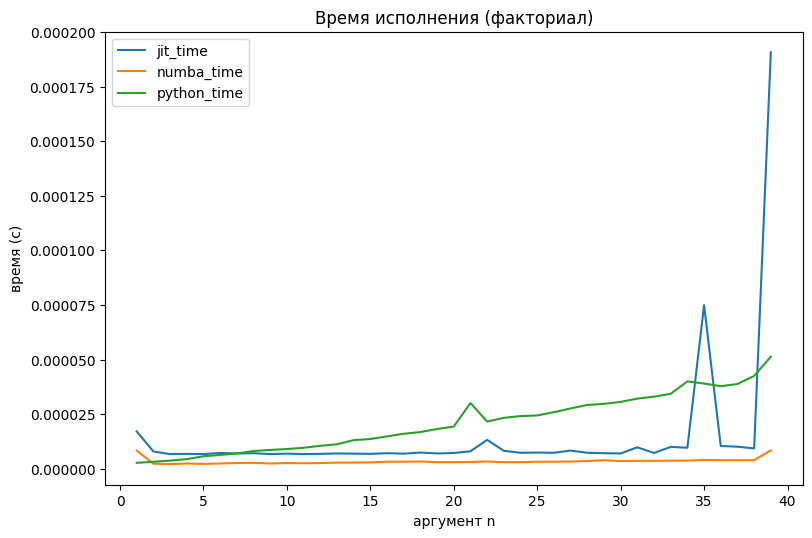

In [79]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_fact_time, label='jit_time')
plt.plot(args, numba_fact_time, label='numba_time')
plt.plot(args, python_fact_time, label='python_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (факториал)')
plt.legend()
plt.savefig("report/plots/exec_fact_3.png")
plt.show()

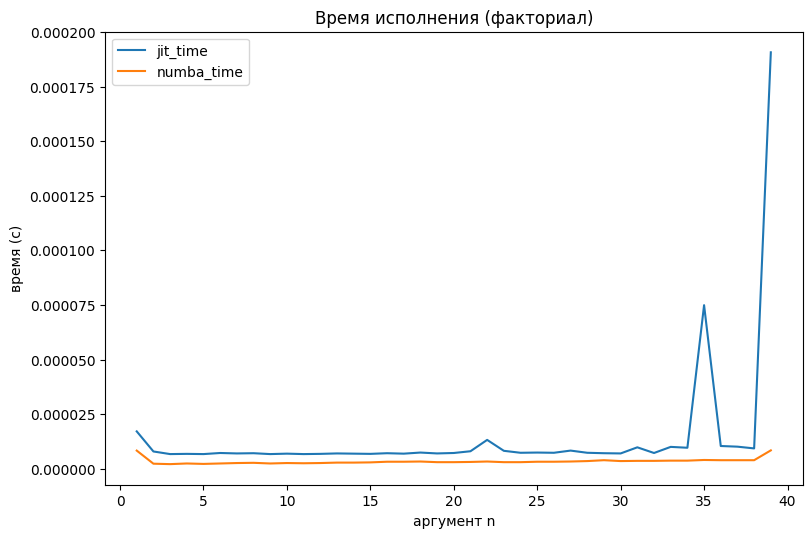

In [80]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_fact_time, label='jit_time')
plt.plot(args, numba_fact_time, label='numba_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (факториал)')
plt.legend()
plt.savefig("report/plots/exec_fact_3.png")
plt.show()

### Функция поиска n-го простого числа (наивная реализация)

In [58]:
def py_n_primary(n: int) -> int:
    count: int = 0
    number: int = 2
    while count < n:
        i: int = 2
        is_prime: bool = True
        while i < number:
            if number % i == 0:
                is_prime = False
                break
            i += 1
        if is_prime:
            count += 1
        number += 1
    return number - 1


jit_n_primary, numba_n_primary = get_jit_numba_realisations(py_n_primary)

In [82]:
arg = 1000
print(f"prim({arg}) = {jit_n_primary(arg)}")
args = range(10, 2010, 100)
jit_n_primary_time, numba_n_primary_time, python_n_primary_time = [], [], []
for arg in args:
    jit_n_primary_time.append(timeit(lambda: jit_n_primary(arg), number=1))
    numba_n_primary_time.append(timeit(lambda: numba_n_primary(arg), number=1))
    python_n_primary_time.append(timeit(lambda: py_n_primary(arg), number=1))
print(jit_n_primary_time)
print(numba_n_primary_time)
print(python_n_primary_time)

prim(1000) = 7919
[9.100011084228754e-06, 0.00020719997701235116, 0.0004391999973449856, 0.0010005999938584864, 0.0018428000039421022, 0.002985499973874539, 0.004382299986900762, 0.006068799993954599, 0.008072800002992153, 0.010272700019413605, 0.013287200010381639, 0.015859699982684106, 0.018952999991597608, 0.02258859999710694, 0.026284199993824586, 0.03030030001536943, 0.034987199993338436, 0.03977820000727661, 0.044524400000227615, 0.04992849999689497]
[5.80001506023109e-06, 0.0001112000027205795, 0.0004372999828774482, 0.0010204999998677522, 0.001847300009103492, 0.002974000002723187, 0.004363599990028888, 0.006058099999791011, 0.008223900018492714, 0.010242999996989965, 0.013160900009097531, 0.015671700006350875, 0.018854099995223805, 0.022339000017382205, 0.02593259999412112, 0.02990180000779219, 0.034939899982418865, 0.03953989999718033, 0.04424209997523576, 0.0490503000037279]
[9.300012607127428e-06, 0.001340099988738075, 0.005856200004927814, 0.014209400018444285, 0.028922400

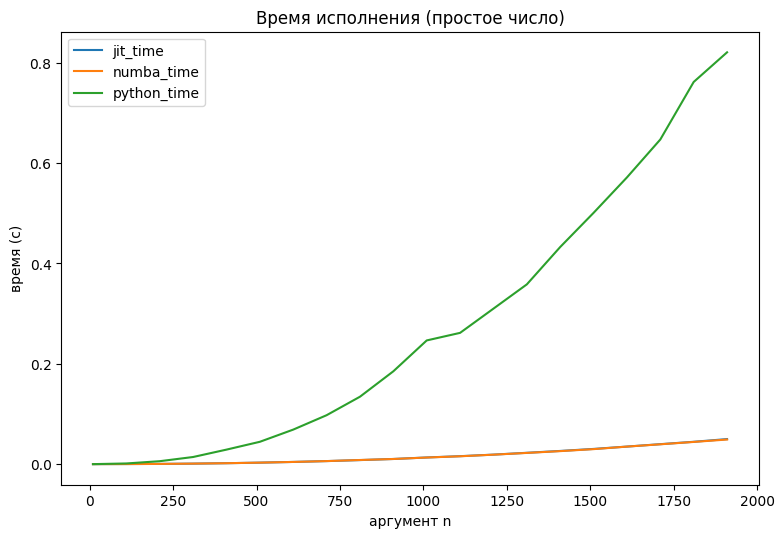

In [83]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_n_primary_time, label='jit_time')
plt.plot(args, numba_n_primary_time, label='numba_time')
plt.plot(args, python_n_primary_time, label='python_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время исполнения (простое число)')
plt.legend()
plt.savefig("report/plots/exec_prim_3.png")
plt.show()

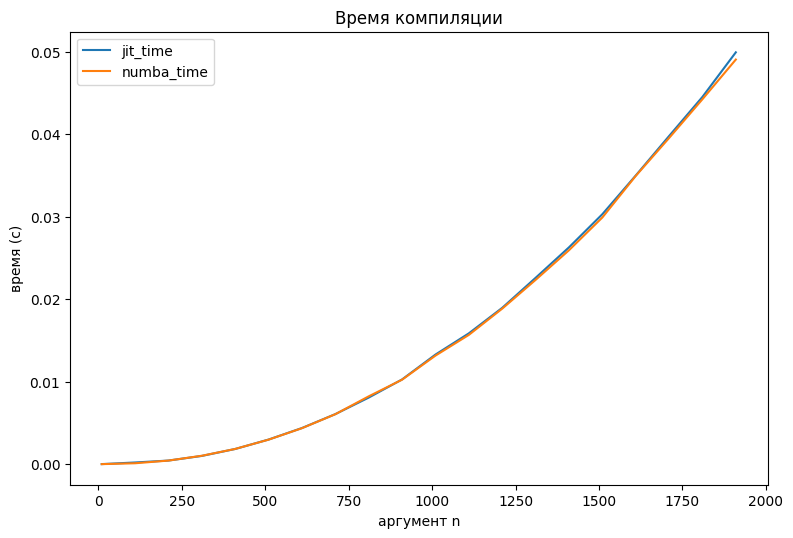

In [84]:
plt.figure(figsize=(9, 6), dpi=100, facecolor=(1,1,1))
plt.plot(args, jit_n_primary_time, label='jit_time')
plt.plot(args, numba_n_primary_time, label='numba_time')
plt.xlabel('аргумент n')
plt.ylabel('время (с)')
plt.title('Время компиляции')
plt.legend()
plt.savefig("report/plots/exec_prim_2.png")
plt.show()

Выводы:
* Аналогичны выводам по экспоненте